In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# torch
import torch
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import CSVLogger

# vision
#from torchvision.utils import save_image

# utils
import random

# custom utils
from datasets.dataset import *
from helper_utils import display_utils, my_utils
from models.smp_model import CatSegModel
from models.model_utils import build_trainer, infer_set

In [3]:
# setup
torch.set_float32_matmul_precision('high')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Configuration
Load Configuration:

In [4]:
config_name = "Unet_efficientnet-b3_train.json"
paths, config, data_transforms = my_utils.load_configs(config_name, 'paths_pc.json') # select paths file

,Key,Value
0,NAME,Unet_efficientnet-b3_pretrained_DiceLoss
1,MODE,train
2,NUM_EPOCHS,10
3,CLASSES,[pupil]
4,IN_CH,3
5,ARCH,Unet
6,ENCODER,efficientnet-b3
7,ENCODER_WEIGHTS,imagenet
8,LOSS,DiceLoss
9,LR,0.0001


,0,1
0,ToImage,{}
1,RandomHorizontalFlip,{'p': 0.5}
2,RandomVerticalFlip,{'p': 0.5}
3,ColorJitter,"{'brightness': 0.2, 'contrast': 0.2, 'saturati..."
4,RandomPerspective,"{'distortion_scale': 0.2, 'p': 0.7}"


,0,1
0,CenterCrop,{'size': 640}
1,ToImage,{}


,0,1
0,CenterCrop,{'size': 640}
1,ToImage,{}


### Data prep

Build dataset:

In [5]:
# get files
train_dataset = SegmentationDataset(os.path.join(paths['train_data_root'], 'train'), data_transforms['train'])
valid_dataset = SegmentationDataset(os.path.join(paths['train_data_root'], 'valid'), data_transforms['valid'])

# dataloaders
train_dl = DataLoader(train_dataset, batch_size=3, shuffle=True, pin_memory=True)#, num_workers=n_cpu)
valid_dl = DataLoader(valid_dataset, batch_size=1, shuffle=False)#, num_workers=n_cpu)

Plot a few images for example:

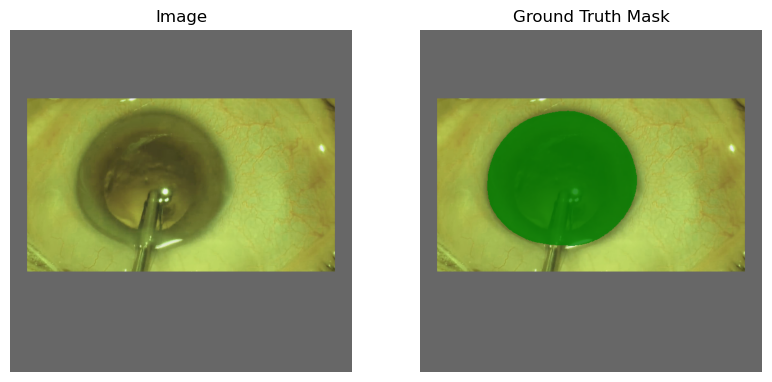

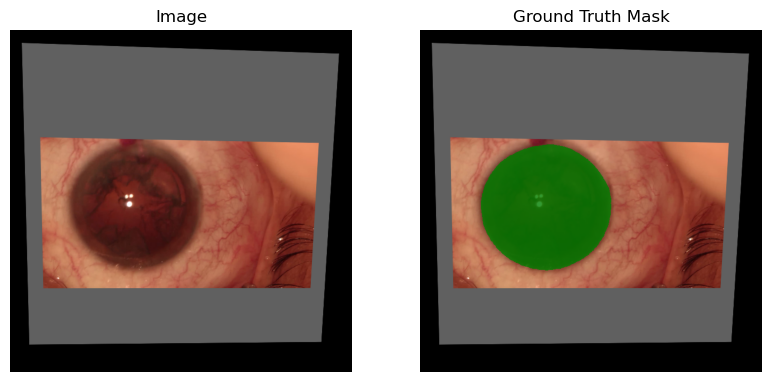

In [6]:
for _ in range(2):
    index = random.randint(0, len(train_dataset) - 1)
    display_utils.display_sample(train_dataset, index)

### Build model
Config load:

In [7]:
# build model
if config['MODE'] == 'train':
    model = CatSegModel(config)
    
elif config['MODE'] == 'load':
    # load model from checkpoint
    model = CatSegModel.load_from_checkpoint(
        checkpoint_path=os.path.join(paths['checkpoint_path'], config['NAME']+'_best-checkpoint.ckpt'),
        hparams_file=os.path.join(paths['log_path'], 'hparams.yaml')
    )

#### Build the PL trainer:

In [8]:
trainer, train_logger = build_trainer(config, paths)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


#### Train and plot convergance:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | Unet     | 13.2 M | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------------------------
13.2 M    Trainable params
0         Non-trainable params
13.2 M    Total params
52.636    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Jonathan\.conda\envs\custom_CatSemSeg\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


<Figure size 1500x500 with 0 Axes>

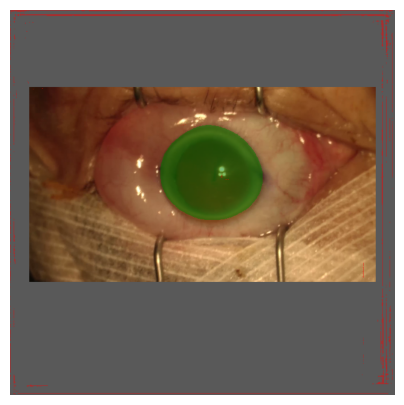

c:\Users\Jonathan\.conda\envs\custom_CatSemSeg\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

In [9]:
plot_metrics = ['dataset_iou', 'dataset_loss']

if config['MODE'] == 'train':
    # train using the included logger
    trainer.fit(model, 
        train_dataloaders=train_dl, 
        val_dataloaders=valid_dl)
    
    if plot_metrics != None:
        pth = os.path.join(train_logger.log_dir, 'metrics.csv')
        display_utils.plot_losses(pth, plot_metrics)

### Test and Evaluate

In [ ]:
test_csv_logger = CSVLogger(paths['log_path'], 'test')
trainer.logger = test_csv_logger

with torch.no_grad():
    model.eval()
    trainer.test(model= model, dataloaders = valid_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\jonathan\.conda\envs\custom_CatSemSeg\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    test_dataset_iou        0.9787966012954712
    test_dataset_loss      0.011343351565301418
   test_per_image_iou        0.978985071182251
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Test preformance:

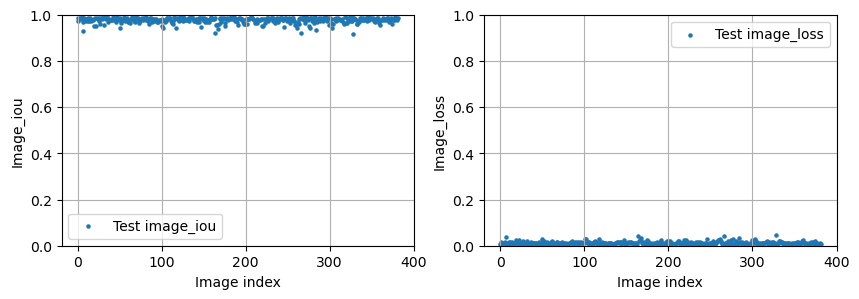

In [ ]:
pth = os.path.join(paths['log_path'], 'test', 'metrics.csv')
display_utils.plot_losses(pth, ['image_iou', 'image_loss'], test = True)

### Generate marked images
We will begin by generating the predicted masks on the test dataset, and save them to disk in `train_data_root\infer\NAME`.
Also, we will display a few images.

<Figure size 1500x500 with 0 Axes>

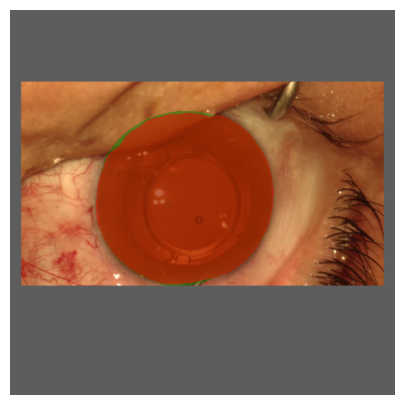

<Figure size 1500x500 with 0 Axes>

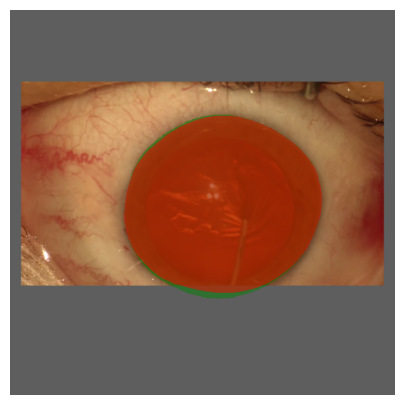

<Figure size 1500x500 with 0 Axes>

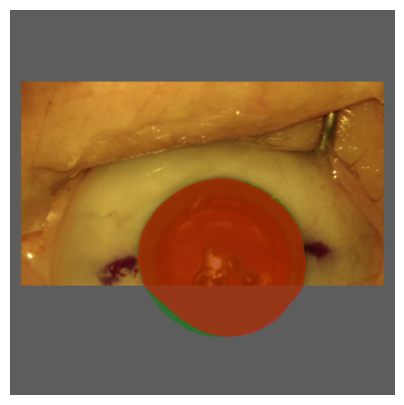

In [ ]:
pth = os.path.join(paths['train_data_root'], 'infer', config['NAME'])
infer_set(model, device, pth, dataset=test_dl.dataset, save=False, print=3)

#### Test Data
For qualiative evaluation we will generate and display images from out-of-dataset.

First we need to load the inference dataset `infer_dataset`:

In [ ]:
data_transforms['infer'] = T.Compose([
    T.Resize((640 - 256, 640 - 32)),
    T.Pad([16, 128, 16, 128], (0.5, 0.5, 0.5)),
    T.CenterCrop(640),
    T.ToImage(),
    T.ToDtype(torch.uint8, scale=True),
])

In [ ]:
# build dataset
infer_dataset = SegmentationInferenceDataset(paths['inference_data_root'], transform=data_transforms['infer'], is_stereo=True)

Generate the masks:

<Figure size 1500x500 with 0 Axes>

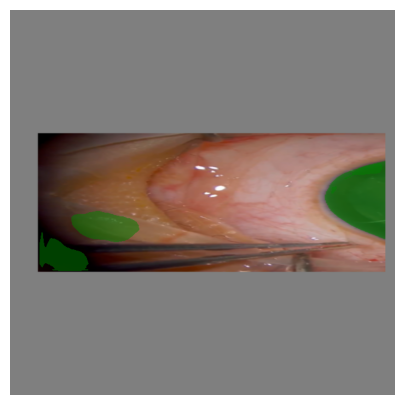

<Figure size 1500x500 with 0 Axes>

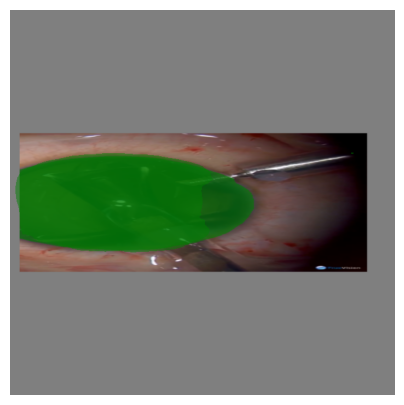

<Figure size 1500x500 with 0 Axes>

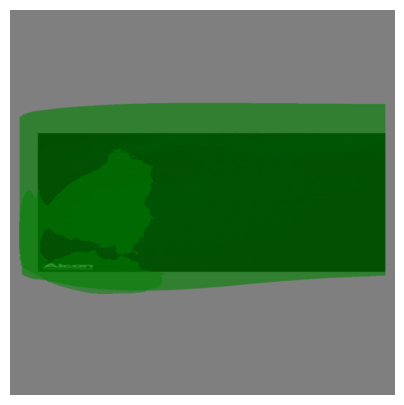

<Figure size 1500x500 with 0 Axes>

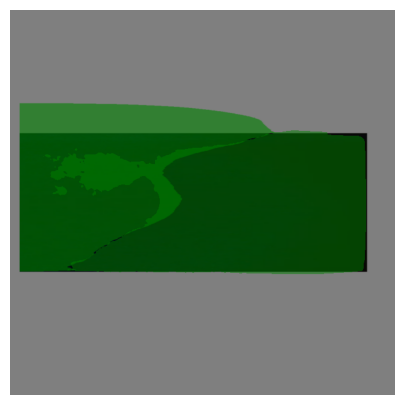

<Figure size 1500x500 with 0 Axes>

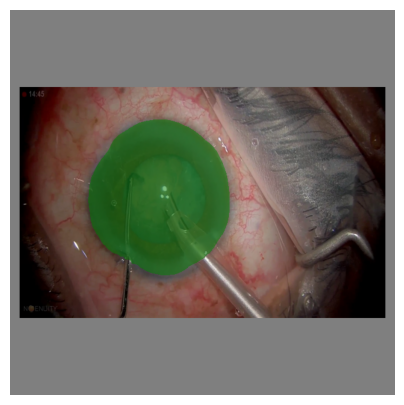

In [ ]:
pth = os.path.join(paths['inference_save_path'])
infer_set(model, device, pth, dataset=infer_dataset, save=True, print=5)